# Fellowship AI challenge

## Challenge goals
1. Problem solving ability - did you understand the problem correctly, and did you take logical steps to solve it?  
2. Machine learning skills - what sort of models did you use? How rigorous was your exploratory analysis of the data, your choice and fine tuning of models, and your assessment of results.  
3. Communication skills - is your solution readable and well explained? Messiness and raw code with no explanation does not reflect well on your potential for working well with our business partners during the fellowship.

## Mistakes to avoid

- Skipping exploratory analysis and feature engineering  
Do not jump straight into fitting models without demonstrating to us, in your Jupyter notebook, that you have understood and thought about the dataset.

- Choosing models with no explanation  
Please use the notebook to explain your thought process. We care about this as much as we care about your results.

- Unreadable notebooks  
Make sure to run your notebook before sharing so that we can see the results. We won't be running your code on our machines. On the flip side, please do not print out the entire dataset or endless rounds of epochs.

- Overly simplistic final results  
Your final results should consist of more than a single number or percentage printout. Explain why you chose the success metrics you chose, and analyze what your output means.

## Questions to Consider
Ask yourself why would they have selected this problem for the challenge? What are some gotchas in this domain I should know about?  
What is the highest level of accuracy that others have achieved with this dataset or similar problems / datasets ?  
What types of visualizations will help me grasp the nature of the problem / data?  
What feature engineering might help improve the signal?  
Which modeling techniques are good at capturing the types of relationships I see in this data?  
Now that I have a model, how can I be sure that I didn't introduce a bug in the code? If results are too good to be true, they probably are!  
What are some of the weaknesses of the model and and how can the model be improved with additional work?

## Understand OmniGlot

Resources 
Omniglot paper - http://science.sciencemag.org/content/sci/350/6266/1332.full.pdf  
Keras - https://sorenbouma.github.io/blog/oneshot/  
CS231n - http://cs231n.stanford.edu/reports/2017/pdfs/131.pdf  
Siamese nets paper - http://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf  

## Exploring the dataset

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

In [3]:
import torch
import torch.nn as nn

In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [5]:
omniglot_trainset = datasets.Omniglot(root='./omniglot_data/', download=True, background=True, transform=None)

Files already downloaded and verified


In [6]:
omniglot_evalset = datasets.Omniglot(root='./omniglot_data/', download=True, background=False, transform=None)

Files already downloaded and verified


### basic stats about the dataset

In [7]:
len(omniglot_trainset), len(omniglot_evalset)

(19280, 13180)

In [8]:
len(omniglot_trainset._alphabets), len(omniglot_trainset._characters)

(30, 964)

In [9]:
omniglot_trainset._alphabets

['Gujarati',
 'Korean',
 'Arcadian',
 'Malay_(Jawi_-_Arabic)',
 'Grantha',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Balinese',
 'Futurama',
 'N_Ko',
 'Burmese_(Myanmar)',
 'Anglo-Saxon_Futhorc',
 'Mkhedruli_(Georgian)',
 'Latin',
 'Braille',
 'Sanskrit',
 'Japanese_(hiragana)',
 'Tagalog',
 'Greek',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(katakana)',
 'Early_Aramaic',
 'Hebrew',
 'Tifinagh',
 'Asomtavruli_(Georgian)',
 'Armenian',
 'Syriac_(Estrangelo)',
 'Alphabet_of_the_Magi',
 'Cyrillic',
 'Bengali',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)']

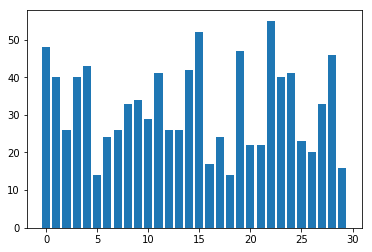

In [10]:
per_language_count = dict()
for a in omniglot_trainset._alphabets:
    per_language_count['{}'.format(a)] = len(os.listdir(os.path.join(omniglot_trainset.target_folder, a)))
plt.bar(range(len(per_language_count)), list(per_language_count.values()))
# plt.xticks(range(len(per_language_count)), list(per_language_count.keys()))
plt.show()

In [11]:
len(omniglot_evalset._alphabets), len(omniglot_evalset._characters)

(20, 659)

In [12]:
omniglot_evalset._alphabets

['Oriya',
 'ULOG',
 'Tengwar',
 'Malayalam',
 'Atlantean',
 'Keble',
 'Manipuri',
 'Gurmukhi',
 'Tibetan',
 'Aurek-Besh',
 'Ge_ez',
 'Angelic',
 'Old_Church_Slavonic_(Cyrillic)',
 'Kannada',
 'Avesta',
 'Mongolian',
 'Syriac_(Serto)',
 'Atemayar_Qelisayer',
 'Sylheti',
 'Glagolitic']

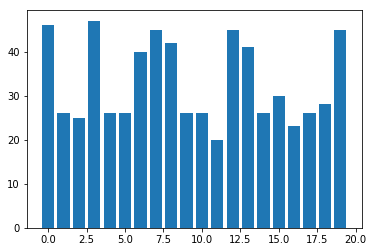

In [13]:
eval_per_lang_count = dict()
for a in omniglot_evalset._alphabets:
    eval_per_lang_count['{}'.format(a)] = len(os.listdir(os.path.join(omniglot_evalset.target_folder, a)))
plt.bar(range(len(eval_per_lang_count)), list(eval_per_lang_count.values()))
# plt.xticks(range(len(eval_per_lang_count)), list(eval_per_lang_count.keys()))
plt.show()

class: Futurama/character09, img shape: (105, 105)


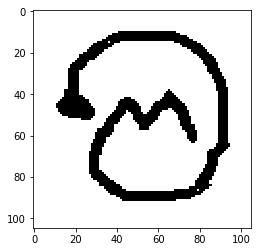

In [14]:
ind = np.random.randint(len(omniglot_trainset))
img, target = omniglot_trainset[ind]
class_name = omniglot_trainset._characters[target]
plt.imshow(np.asarray(img), cmap='gray')
print('class: {}, img shape: {}'.format(class_name, img.size))

class: Malayalam/character31, img shape: (105, 105)


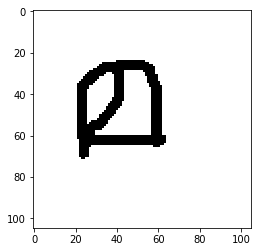

In [15]:
ind = np.random.randint(len(omniglot_evalset))
img, target = omniglot_evalset[ind]
class_name = omniglot_evalset._characters[target]
plt.imshow(np.asarray(img), cmap='gray')
print('class: {}, img shape: {}'.format(class_name, img.size))

# 1 - nearest neighbour from raw pixel values on the training set

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import cv2

In [17]:
def flatten_image(img, size=(32, 32)):
    flat = cv2.resize(img, size).flatten()
    return cv2.normalize(flat, flat, norm_type=cv2.NORM_MINMAX)

In [18]:
flatten_image(np.asarray(img))

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [19]:
rawImages = []
labels = []
for ind, (img, label) in enumerate(omniglot_trainset):
    pixels = flatten_image(np.asarray(img))
    
    rawImages.append(pixels)
    labels.append(label)
    
    if ind > 0 and ind % 1000 == 0:
        print("[INFO] processed {}/{}".format(ind, len(omniglot_trainset)))

[INFO] processed 1000/19280
[INFO] processed 2000/19280
[INFO] processed 3000/19280
[INFO] processed 4000/19280
[INFO] processed 5000/19280
[INFO] processed 6000/19280
[INFO] processed 7000/19280
[INFO] processed 8000/19280
[INFO] processed 9000/19280
[INFO] processed 10000/19280
[INFO] processed 11000/19280
[INFO] processed 12000/19280
[INFO] processed 13000/19280
[INFO] processed 14000/19280
[INFO] processed 15000/19280
[INFO] processed 16000/19280
[INFO] processed 17000/19280
[INFO] processed 18000/19280
[INFO] processed 19000/19280


In [20]:
rawImages = np.array(rawImages)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(rawImages.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 19.28MB


In [21]:
(trainRI, testRI, trainRL, testRL) = train_test_split(rawImages, labels, test_size=0.25, random_state=1791387)

In [22]:
print("[INFO] evaluating raw pixel accuracy...")
model = KNeighborsClassifier(n_neighbors=1)
model.fit(trainRI, trainRL)
acc = model.score(testRI, testRL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 11.04%


## Demo classification run from lake

In [23]:
# !cd one-shot-classification/all_runs/
!python one-shot-classification/all_runs/demo_classification.py

One-shot classification demo with Modified Hausdorff Distance
 run 1 (error 45.0%)
 run 2 (error 35.0%)
 run 3 (error 40.0%)
 run 4 (error 25.0%)
 run 5 (error 30.0%)
 run 6 (error 15.0%)
 run 7 (error 60.0%)
 run 8 (error 35.0%)
 run 9 (error 40.0%)
 run 10 (error 55.0%)
 run 11 (error 15.0%)
 run 12 (error 70.0%)
 run 13 (error 65.0%)
 run 14 (error 35.0%)
 run 15 (error 15.0%)
 run 16 (error 25.0%)
 run 17 (error 30.0%)
 run 18 (error 40.0%)
 run 19 (error 70.0%)
 run 20 (error 30.0%)
 average error 38.75%


## Siamese networks

In [61]:
from dataloader import SiameseTestData, SiameseTrainData
from networks import SiameseNet
from losses import ContrastiveLoss
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import time

In [35]:
trainset = SiameseTrainData(omniglot_trainset)

TypeError: Invalid dimensions for image data

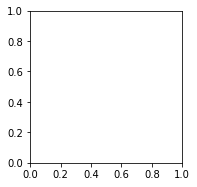

In [36]:
img1, img2, target = next(iter(trainset))
plt.subplot(121)
plt.imshow(np.asarray(img2), cmap='gray')
plt.subplot(122)
plt.imshow(np.asarray(img1), cmap='gray')
print(target)

In [ ]:
testset = SiameseTestData(omniglot_evalset)

In [ ]:
i = 0
for img1, img2 in testset:
    i+=1
    if i == 5:
        break
plt.subplot(121)
plt.imshow(np.asarray(img2), cmap='gray')
plt.subplot(122)
plt.imshow(np.asarray(img1), cmap='gray')

In [43]:
input_size = 105
learning_rate = 1e3
epochs = 200

In [44]:

data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    }

In [45]:
from torch.utils.data.sampler import SubsetRandomSampler

In [46]:
omniglot_trainset = datasets.Omniglot(root='./omniglot_data/', download=True, background=True, transform=data_transforms['train'])
omniglot_valset = datasets.Omniglot(root='./omniglot_data/', download=True, background=True, transform=data_transforms['val'])
omniglot_evalset = datasets.Omniglot(root='./omniglot_data/', download=True, background=False, transform=data_transforms['val'])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [47]:
indices = list(range(len(omniglot_trainset)))
split = int(0.15 * len(omniglot_trainset))
train_indices = indices[:split]
val_indices = indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

trainset = SiameseTrainData(omniglot_trainset)
valset = SiameseTestData(omniglot_valset)
testset = SiameseTestData(omniglot_evalset)

In [53]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler, num_workers=4, pin_memory=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, sampler=val_sampler, num_workers=4, pin_memory=False)

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
class KochNet(nn.Module):

    def __init__(self):
        super(KochNet, self).__init__()
        self.features = nn.Sequential(
            # 1x105x105
            nn.Conv2d(1, 64, kernel_size=10),
            # 64x96x96
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2),
            # 64x48x48
            nn.Conv2d(64, 128, kernel_size=7),
            # 128x42x42
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # 128x21x21
            nn.Conv2d(128, 128, kernel_size=4),
            # 128x18x18
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # 128x9x9
            nn.Conv2d(128, 256, kernel_size=4),
            # 256x6x6
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid(),
        )
        self.output = nn.Linear(4096, 1)
        

    def forward(self, x1, x2):
        x1 = self.features(x1)
        x1 = x1.view(x1.size(0), 256 * 6 * 6)
        x1 = self.fc(x1)
        x2 = self.features(x2)
        x2 = x2.view(x2.size(0), 256 * 6 * 6)
        x2 = self.fc(x2)
        dist = torch.abs(x1 - x2)
        out = self.output(dist)
        return out

In [56]:
model = KochNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
T_max = epochs
eta_min = 0.01
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
criterion = nn.BCEWithLogitsLoss()

In [30]:
img1, img2, targets = next(iter(trainloader))
output = model(img1, img2)

torch.Size([64, 1, 105, 105])


In [57]:
from utils import AverageMeter

In [62]:
def train(train_loader, model, criterion, optimizer, epoch, device, debug=False, print_freq=200):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (imgs1, imgs2, labels) in enumerate(train_loader):
        data_time.update(time.time() - end)

        imgs1 = imgs1.to(device)
        imgs2 = imgs2.to(device)
        targets.to(device)

        output = model(imgs1, img2)

        loss = criterion(output, targets)

        losses.update(loss.item(), imgs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})'.format(
                      epoch, batch_idx, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses))
        if debug:
            break

    return losses.avg

In [ ]:
train(trainloader, model, criterion, optimizer, 1, device, True, 1)